In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### My key


In [15]:
CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ' # your Foursquare ID
CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM' # your Foursquare Secret
VERSION = '20180604'


### Function

In [16]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### NYC data

In [17]:

ny_data = get_new_york_data()
ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [18]:
ny_data.shape


(306, 4)

### Exploratory Data Analysis

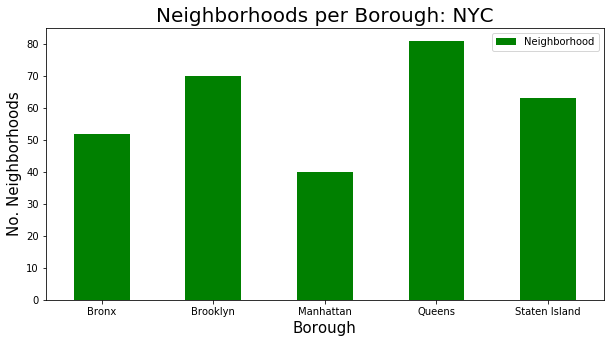

In [82]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.savefig('NYC_1.png')
plt.show()


### Let's analyze further and see how many Chinese restaurants there are in each neighborhood and borough. After it, graph the results

In [84]:

# queens has most neighborhoods
# prepare neighborhood list that contains Chinese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 1 / 306 ) Chinese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 1 / 306 ) Chinese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 1 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 1 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 1 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 1 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 1 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 1 / 306 ) Chinese Restaurants in Norwood, Bronx:0
['

( 1 / 306 ) Chinese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 1 / 306 ) Chinese Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 1 / 306 ) Chinese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 1 / 306 ) Chinese Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 1 / 306 ) Chinese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 1 / 306 ) Chinese Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 1 / 306 ) Chinese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 1 / 306 ) Chinese Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 1 / 306 ) Chinese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 1 / 306 ) Chinese Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 1 / 306 ) Chinese Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 1 / 306 ) Chinese Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 1 / 306 ) Chinese Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 1 / 306 ) Chinese Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 1 / 306 ) Chinese Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 1 / 306 ) Chinese Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 1 / 306 ) Chinese Restaurants

( 1 / 306 ) Chinese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 1 / 306 ) Chinese Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 1 / 306 ) Chinese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 1 / 306 ) Chinese Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 1 / 306 ) Chinese Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 1 / 306 ) Chinese Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 1 / 306 ) Chinese Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 1 / 306 ) Chinese Restaurants in Port Richmond, Staten I

( 1 / 306 ) Chinese Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 1 / 306 ) Chinese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 1 / 306 ) Chinese Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 1 / 306 ) Chinese Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 1 / 306 ) Chinese Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 1 / 306 ) Chinese Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 1 / 306 ) Chinese Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 1 / 306 ) Chinese Restaurants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 1 / 306 

In [91]:
chinese_rest_ny.head()

Borough    Neighborhood                        ID  \
0   Bronx      Co-op City  4c9d5f2654c8a1cd2e71834b   
1   Bronx     Eastchester  4dabc3dc93a04642f09ccabd   
2   Bronx         Norwood  4e41d2c4b61ca5ba3b1f9c6b   
3   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   
4   Bronx    Bedford Park  4e4d0387bd413c4cc66dfd72   

                           Name  
0  Guang Hui Chinese Restaurant  
1  Xing Lung Chinese Restaurant  
2            Ming Liang Kitchen  
3    Mr. Q's Chinese Restaurant  
4  Hung Hing Chinese Restaurant

In [86]:
chinese_rest_ny.shape


(180, 4)

In [92]:
df_c= chinese_rest_ny

In [93]:
#df_c =bpd.read_csv('chinese_rest.csv', index_col=0)

In [94]:
df_c.shape

(180, 4)

In [110]:
df_c['Neighborhood'].value_counts()

Chinatown              8
Washington Heights     4
Lower East Side        3
Greenwich Village      3
East Village           3
Little Italy           3
Queensboro Hill        3
Fort Hamilton          3
Downtown               3
Bensonhurst            3
Bedford Park           3
Bulls Head             3
Flushing               3
Little Neck            3
West Farms             2
Rego Park              2
Parkchester            2
Beechhurst             2
Willowbrook            2
Bayside                2
New Lots               2
Elmhurst               2
Far Rockaway           2
Inwood                 2
Howard Beach           2
Homecrest              2
Windsor Terrace        2
Lenox Hill             2
Oakland Gardens        2
Sutton Place           2
Brooklyn Heights       2
Ravenswood             2
East New York          2
Soundview              2
Kew Gardens            2
Sunnyside              2
Central Harlem         2
Ditmas Park            2
West Village           2
Mill Basin             2


In [115]:
df_c[df_c['Neighborhood'] =='Washington Heights']

Borough        Neighborhood                        ID  \
62  Manhattan  Washington Heights  4b292f38f964a520939a24e3   
63  Manhattan  Washington Heights  4b8d55aef964a52050f532e3   
64  Manhattan  Washington Heights  4b3fe94af964a520e2b125e3   
65  Manhattan  Washington Heights  4aaed36bf964a520736320e3   

                             Name  
62                    Yang Garden  
63                    Golden Star  
64       No. 1 Chinese Restaurant  
65  Great Wall Chinese Restaurant

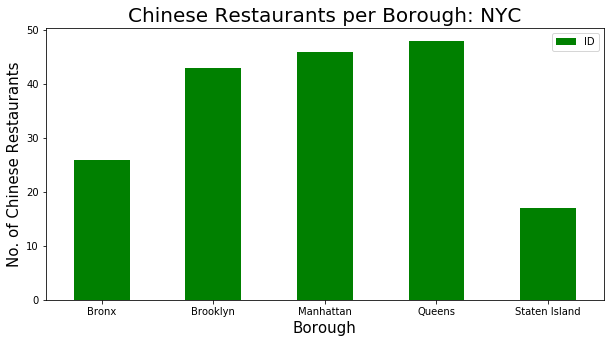

In [95]:
df_c.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.savefig('NYC_2.png')
plt.show()

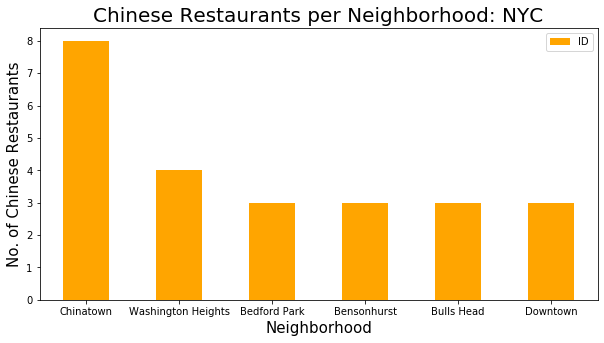

In [96]:
NOofNeigh = 6 # top number for graphing all the same past 6
df_c.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color= 'orange')
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.savefig('NYC_3.png')
plt.show()


In [107]:
df_c.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh)

Neighborhood
Chinatown             8
Washington Heights    4
Bedford Park          3
Bensonhurst           3
Bulls Head            3
Downtown              3
Name: ID, dtype: int64

In [97]:
df_c[df_c['Neighborhood']=='Chinatown']

Borough Neighborhood                        ID  \
54  Manhattan    Chinatown  4db3374590a0843f295fb69b   
55  Manhattan    Chinatown  4a96bf8ff964a520ce2620e3   
56  Manhattan    Chinatown  5894c9a15e56b417cf79e553   
57  Manhattan    Chinatown  5c965dad5455b2002c058659   
58  Manhattan    Chinatown  59d828f0916bc1155fde2c04   
59  Manhattan    Chinatown  3fd66200f964a520b1ea1ee3   
60  Manhattan    Chinatown  59ad625a2619ee5cdded881f   
61  Manhattan    Chinatown  3fd66200f964a520ede41ee3   

                                 Name  
54                      Spicy Village  
55  Wah Fung Number 1 Fast Food 華豐快餐店  
56                 Xi'an Famous Foods  
57           Yi Ji Shi Mo Noodle Corp  
58                           Hwa Yuan  
59              Great N.Y. Noodletown  
60                 House Special 甘來飯店  
61                   Big Wong King 大旺

So the Chinatown in Manhattan has the highest number of chinese Restaurants with a total count of 8.

Now we will get the ranking of each restaurant for further analysis.

In [99]:
CLIENT_ID = '0XEBFNIFSQ0GVXN1GTEOTBIXLY0QYPRKYFPSV3TQULGONMIK' # your Foursquare ID
CLIENT_SECRET = 'GACWDCWQZINOFW2YIQFMZFJHNDP53KLBJDMTAS5L0FGMJ40I' # your Foursquare Secret
VERSION = '20201127'

In [100]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in df_c.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(df_c),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


{'meta': {'code': 200, 'requestId': '5fca8fd527dc4e1dbb610f33'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5fca8fd64e19e45ea55f5b10'}, 'response': {'venue': {'id': '4e41d2c4b61ca5ba3b1f9c6b', 'name': 'Ming Liang Kitchen', 'contact': {'phone': '71854707780779', 'formattedPhone': '71854707780779'}, 'location': {'address': '236 E Gun Hill Rd', 'crossStreet': 'Kings College Place', 'lat': 40.879876, 'lng': -73.87662900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879876, 'lng': -73.87662900000001}, {'label': 'entrance', 'lat': 40.879844, 'lng': -73.87664}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236 E Gun Hill Rd (Kings College Place)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ming-liang-kitchen/4e41d2c4b61ca5ba3b1f9c6b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',

{'meta': {'code': 200, 'requestId': '5fca8fd6c07cbe19c5052806'}, 'response': {'venue': {'id': '4e4d0387bd413c4cc66dfd72', 'name': 'Hung Hing Chinese Restaurant', 'contact': {'phone': '7185625050', 'formattedPhone': '(718) 562-5050'}, 'location': {'address': '239 Bedford Park Blvd', 'lat': 40.871181206606806, 'lng': -73.88675855253665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871181206606806, 'lng': -73.88675855253665}, {'label': 'entrance', 'lat': 40.871189, 'lng': -73.886476}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hung-hing-chinese-restaurant/4e4d0387bd413c4cc66dfd72', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5fca8fd7a5b71d40e9c9221f'}, 'response': {'venue': {'id': '4ccf58277f56a1434cfec6a6', 'name': 'Wings Chinese Restaurant', 'contact': {'phone': '7182994613', 'formattedPhone': '(718) 299-4613'}, 'location': {'address': '879 E Tremont Ave', 'lat': 40.843266, 'lng': -73.88590500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.843266, 'lng': -73.88590500000001}, {'label': 'entrance', 'lat': 40.842944, 'lng': -73.885881}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['879 E Tremont Ave', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wings-chinese-restaurant/4ccf58277f56a1434cfec6a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5fca8fd89689f0727eff1baa'}, 'response': {'venue': {'id': '4df3e68688772e1f81559d14', 'name': 'Good Choice Chinese Restaurant', 'contact': {'phone': '7185858866', 'formattedPhone': '(718) 585-8866'}, 'location': {'address': '570 E 138th St', 'crossStreet': 'at St. Anns Ave.', 'lat': 40.806515999999995, 'lng': -73.917477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.806515999999995, 'lng': -73.917477}, {'label': 'entrance', 'lat': 40.806629, 'lng': -73.917397}], 'postalCode': '10454', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['570 E 138th St (at St. Anns Ave.)', 'Bronx, NY 10454', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-choice-chinese-restaurant/4df3e68688772e1f81559d14', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5fca8fd824f6880346e7cb62'}, 'response': {'venue': {'id': '4e656e8252b1260c14683b4b', 'name': 'Kee Hing Restaurant', 'contact': {'phone': '7189911105', 'formattedPhone': '(718) 991-1105'}, 'location': {'address': '845 Soundview Ave', 'crossStreet': 'Story Ave.', 'lat': 40.822140999999995, 'lng': -73.8677, 'labeledLatLngs': [{'label': 'display', 'lat': 40.822140999999995, 'lng': -73.8677}, {'label': 'entrance', 'lat': 40.822374, 'lng': -73.867704}], 'postalCode': '10473', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['845 Soundview Ave (Story Ave.)', 'Bronx, NY 10473', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kee-hing-restaurant/4e656e8252b1260c14683b4b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, '

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4da9c2358154abafc29ba5d8
( 18 / 180 ) processed
{'meta': {'code': 200, 'requestId': '5fca8fd903267f4682c1f1fc'}, 'response': {'venue': {'id': '4dcdb39352b1f8915b842d57', 'name': 'Joy Garden', 'contact': {'phone': '7185181242', 'formattedPhone': '(718) 518-1242'}, 'location': {'address': '687 Morris Park Ave', 'crossStreet': 'White Plains Rd', 'lat': 40.845357, 'lng': -73.866567, 'labeledLatLngs': [{'label': 'display', 'lat': 40.845357, 'lng': -73.866567}, {'label': 'entrance', 'lat': 40.845284, 'lng': -73.866512}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['687 Morris Park Ave (White Plains Rd)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joy-garden/4dcdb39352b1f8915b842d57', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaura

{'meta': {'code': 200, 'requestId': '5fca8fd982244217e643648e'}, 'response': {'venue': {'id': '4e4dd9bcbd4101d0d79cbeb3', 'name': 'King Hing', 'contact': {'phone': '7182397723', 'formattedPhone': '(718) 239-7723'}, 'location': {'address': '3227 Westchester Ave', 'lat': 40.852266, 'lng': -73.829225, 'labeledLatLngs': [{'label': 'display', 'lat': 40.852266, 'lng': -73.829225}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3227 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-hing/4e4dd9bcbd4101d0d79cbeb3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'hasMenu

Index: []
No data available for id= 4e4cd93fbd413c4cc66ca721
( 24 / 180 ) processed
{'meta': {'code': 200, 'requestId': '5fca8fda9854b71efb6fce38'}, 'response': {'venue': {'id': '4c2169947e85c928b88aba21', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182592831', 'formattedPhone': '(718) 259-2831', 'twitter': 'pandaexpress'}, 'location': {'address': '7323 20th Ave', 'lat': 40.611388, 'lng': -73.99078399999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611388, 'lng': -73.99078399999999}], 'postalCode': '11204', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7323 20th Ave', 'Brooklyn, NY 11204', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4c2169947e85c928b88aba21', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', '

{'meta': {'code': 200, 'requestId': '5fca8fdb037f4c3938218679'}, 'response': {'venue': {'id': '4d7171341c01b60ccebe14c7', 'name': 'Nueva Victoria Restaurant', 'contact': {'phone': '7184312938', 'formattedPhone': '(718) 431-2938', 'twitter': 'newvictory'}, 'location': {'address': '4803 5th Ave', 'lat': 40.645984999999996, 'lng': -74.009117, 'labeledLatLngs': [{'label': 'display', 'lat': 40.645984999999996, 'lng': -74.009117}, {'label': 'entrance', 'lat': 40.646028, 'lng': -74.009181}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4803 5th Ave', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nueva-victoria-restaurant/4d7171341c01b60ccebe14c7', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prima

Index: []
No data available for id= 4d91f9a1d7b1236a6e343c38
( 29 / 180 ) processed
{'meta': {'code': 200, 'requestId': '5fca8fdc70ed9c382a761166'}, 'response': {'venue': {'id': '4e6175d1a80951b31816041f', 'name': 'Good Taste Chinese Food', 'contact': {'phone': '7182211112', 'formattedPhone': '(718) 221-1112'}, 'location': {'address': '235 Kingston Ave', 'lat': 40.6719207288499, 'lng': -73.9419622237335, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6719207288499, 'lng': -73.9419622237335}, {'label': 'entrance', 'lat': 40.671888, 'lng': -73.94184}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['235 Kingston Ave', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-food/4e6175d1a80951b31816041f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5fca8fdc96525d38220bde15'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5fca8fddf853e9681db9a806'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fca8fde37f45509df60a373'}, 'response': {'venue': {'id': '4c60a7cede6920a15f9d9664', 'name': "Michael and Ping's", 'contact': {'phone': '7187880017', 'formattedPhone': '(718) 788-0017', 'facebook': '107321149195', 'facebookUsername': 'michaelandpings', 'facebookName': "Michael & Ping's - Modern Chinese Take-out"}, 'location': {'address': '437 3rd Ave', 'crossStreet': 'btwn 7th & 8th St.', 'lat': 40.67216239483681, 'lng': -73.99037941409061, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67216239483681, 'lng': -73.99037941409061}, {'label': 'entrance', 'lat': 40.67216, 'lng': -73.990273}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['437 3rd Ave (btwn 7th & 8th St.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michael-and-pings/4c60a7cede6920a15f9d9664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', '

{'meta': {'code': 200, 'requestId': '5fca8fde4419a9763d5bd8a2'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '5fca8fde37f45509df60a647'}, 'response': {'venue': {'id': '4dd1b576c65b9d071f8c6ac1', 'name': 'Golden Horse Restaurant', 'contact': {'phone': '7186491809', 'formattedPhone': '(718) 649-1809'}, 'location': {'address': '792 New Lots Ave', 'crossStreet': 'Elton Ave', 'lat': 40.666676, 'lng': -73.881236, 'labeledLatLngs': [{'label': 'display', 'lat': 40.666676, 'lng': -73.881236}, {'label': 'entrance', 'lat': 40.666849, 'lng': -73.881326}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['792 New Lots Ave (Elton Ave)', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-horse-restaurant/4dd1b576c65b9d071f8c6ac1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5fca8fdfaae4a50da488da8b'}, 'response': {'venue': {'id': '4a71ff01f964a52016da1fe3', 'name': 'Kum Kau', 'contact': {'phone': '7186381850', 'formattedPhone': '(718) 638-1850'}, 'location': {'address': '463 Myrtle Ave', 'crossStreet': 'btwn Washington Ave & Hall St', 'lat': 40.693373086368084, 'lng': -73.96675330374048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693373086368084, 'lng': -73.96675330374048}, {'label': 'entrance', 'lat': 40.693463, 'lng': -73.966722}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['463 Myrtle Ave (btwn Washington Ave & Hall St)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kum-kau/4a71ff01f964a52016da1fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5fca8fe0e915b64c93cc336d'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'c

{'meta': {'code': 200, 'requestId': '5fca8fe0b1c42f010586bf5b'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5fca8fe16d31c0183b4185da'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

KeyError: 'venue'

In [101]:
chinese_rest_stats_ny.tail()

Borough Neighborhood                        ID                Name Likes  \
45  Brooklyn     Downtown  5db3649a8d15ba00089b4e9b  Xi'an Famous Foods     9   
46  Brooklyn     Downtown  585d72449f25836f2b2b7a1b           Xifu Food    28   
47  Brooklyn  Boerum Hill  585d72449f25836f2b2b7a1b           Xifu Food    28   
48  Brooklyn   Ocean Hill                         0                   0     0   
49  Brooklyn   North Side  58df00318cfe546addb99246  Birds of a Feather   352   

   Rating Tips  
45    8.8    3  
46    8.1   13  
47    8.1   13  
48      0    0  
49      9   75

In [103]:
chinese_rest_stats_ny.shape

(50, 7)

In [79]:
chinese_rest_stats_ny.to_csv('chinese_rest2.csv') # As I move through this project I continue to save data to a .csv file

In [104]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [44]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [48]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating'] = chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [49]:
chinese_rest_stats_ny.describe()

Likes    Rating       Tips
count   50.000000  50.00000  50.000000
mean    20.740000   3.25800   8.220000
std     58.948892   3.64832  17.386706
min      0.000000   0.00000   0.000000
25%      0.000000   0.00000   0.000000
50%      0.000000   0.00000   0.000000
75%      6.000000   6.65000   7.250000
max    352.000000   9.00000  77.000000

In [52]:

# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                                352
Rating                                 9
Tips                                  75
Name: 49, dtype: object

In [53]:
# Resturant with maximum Ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                142
Rating                                 9
Tips                                  50
Name: 31, dtype: object

In [55]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Clinton Hill
ID              4a71ff01f964a52016da1fe3
Name                             Kum Kau
Likes                                109
Rating                               7.9
Tips                                  77
Name: 43, dtype: object

### Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [70]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
25       North Side            9.00
11         Downtown            8.50
3       Boerum Hill            8.10
7      Clinton Hill            7.90
31   Pelham Parkway            7.60
9         Concourse            7.60
37  Windsor Terrace            7.45
0         Bay Ridge            7.30
28       Park Slope            7.20
15      Eastchester            6.70


Above are the top neighborhoods with the highest average ratings of chinese restaurants.

In [71]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
1  Brooklyn        4.357143
0     Bronx        1.859091


Similarly these are the average ratings of Japanese Restaurants for each Borough

## Visuals 

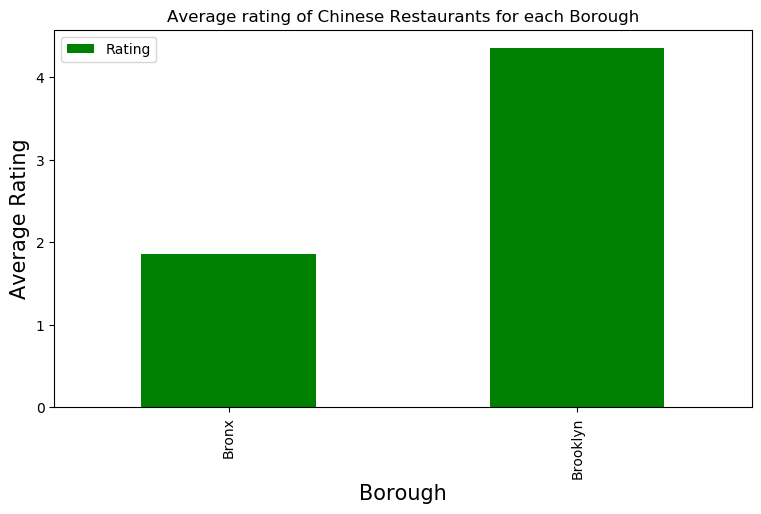

In [72]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()


We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [73]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

Neighborhood  Average Rating
0         Bay Ridge            7.30
3       Boerum Hill            8.10
7      Clinton Hill            7.90
9         Concourse            7.60
11         Downtown            8.50
25       North Side            9.00
28       Park Slope            7.20
31   Pelham Parkway            7.60
37  Windsor Terrace            7.45

In [74]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Borough     Neighborhood   Latitude  Longitude  Average Rating
0  Brooklyn        Bay Ridge  40.625801 -74.030621            7.30
1  Brooklyn      Boerum Hill  40.685683 -73.983748            8.10
2  Brooklyn     Clinton Hill  40.693229 -73.967843            7.90
3     Bronx        Concourse  40.834284 -73.915589            7.60
4  Brooklyn         Downtown  40.690844 -73.983463            8.50
5  Brooklyn       North Side  40.714823 -73.958809            9.00
6  Brooklyn       Park Slope  40.672321 -73.977050            7.20
7     Bronx   Pelham Parkway  40.857413 -73.854756            7.60
8  Brooklyn  Windsor Terrace  40.656946 -73.980073            7.45

Now we will show this data on a map

In [75]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [77]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)